In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Med3D

/content/drive/.shortcut-targets-by-id/1g-o-tVfVDSqEglK2hz1RSl75g30NM35n/Med3D


In [3]:
%pip install scikit-survival --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 68.3 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, animation

from scipy import ndimage
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import torch

from matplotlib import pyplot as plt, animation

import pickle

from torchsummary import summary

from model import generate_model
from my_dataset import My_Dataset

from time import time

In [5]:
class opts:

    data_root = "my_clean/"
    test_size = 0.3
    random_state = 42 #only affects train/test split
    classifier=False
    rna=True
    radiomic=True
    n_seg_classes = 2
    learning_rate = 1e-4
    weight_decay = 1e-6
    eps = 1e-10
    batch_size = 19
    phase = "train" #only affects dataloader
    n_epochs = 100
    input_D = 128 # shapes have to be divisible by 4
    input_H = 192
    input_W = 192
    additional_folder = "missing_files/"
    pretrain_path = "/content/drive/MyDrive/Med3D/trails/final_predictor/Copy of resnet34_128x192x192_039.pth"
    save_path = "trails/"
    new_layer_names = ['conv_seg']
    no_cuda = False
    gpu_id = [0]
    model = "resnet"
    model_depth = 34 # 10, 18, 34, 50, 101, 152, 200
    resnet_shortcut = "B"

args = opts()

In [6]:
# definisco modello lineare fully connected

class CliRadModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(CliRadModel, self).__init__()


    self.layers = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim, dtype=float),
                          torch.nn.ReLU(inplace=True),
                          torch.nn.Linear(hidden_dim, output_dim, dtype=float)
                          )

  def forward(self, x):

    # forward the input through the layers
    x = self.layers(x)

    return x

In [7]:
class RNAModel(torch.nn.Module):
  def __init__(self, input_dim):
    super(RNAModel, self).__init__()


    self.layers = torch.nn.Sequential(torch.nn.Linear(input_dim, input_dim//100, dtype=float), #5268
                           torch.nn.ReLU(inplace=True),
                           torch.nn.Linear(input_dim//100,2, dtype=float)
                           )

  def forward(self, x):

    # forward the input through the layers
    x = self.layers(x)

    return x

In [8]:
class CliRnaRadModel(torch.nn.Module):
    def __init__(self, clirad_model, RNA_model) -> None:
        super(CliRnaRadModel,self).__init__()

        self.clinical_model = clirad_model
        self.RNA_model = RNA_model

        self.layers = torch.nn.Sequential(torch.nn.Linear(125, 125, dtype=float),
                                    torch.nn.ReLU(inplace=True),
                                    torch.nn.Linear(125, 1, dtype=float))

    def forward(self, clinical, RNA, radiomic):

        radiomic = torch.squeeze(radiomic,1)
        clirad = torch.cat([clinical,radiomic],axis=1)

        clirad = self.clinical_model(clirad)#123

        RNA = self.RNA_model(RNA) #2

        x = torch.cat([clirad, RNA],axis=1) #125

        x = self.layers(x) #1

        return x

In [9]:
class CTModel(torch.nn.Module):
  def __init__(self,args,resnet3D):
    super(CTModel, self).__init__()

    self.args = args
    self.resnet3D = resnet3D

    self.num_inputs = int((args.input_D/4)*(args.input_H/4)*(args.input_W/4)*2)

    self.final_layers = torch.nn.Sequential(
                torch.nn.Dropout(p=0.1,inplace=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(self.num_inputs,1024),
                torch.nn.Dropout(p=0.1,inplace=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(1024,1024),
                torch.nn.Dropout(p=0.1,inplace=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(1024,1024),
                torch.nn.Dropout(p=0.1,inplace=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(1024,1),
                )

  def forward(self,x):

    x = self.resnet3D(x)
    x = x.view(x.size(0), -1)
    x = self.final_layers(x)

    return x


In [10]:
class FinalModel(torch.nn.Module):
  def __init__(self,args,resnet3D,clirnarad_model):
    super(FinalModel, self).__init__()

    self.args = args
    self.resnet3D = resnet3D
    self.clirnarad_model = clirnarad_model

    self.num_inputs = int((args.input_D/4)*(args.input_H/4)*(args.input_W/4)*2)

    self.post_resnet3D = torch.nn.Sequential(
                torch.nn.Dropout(p=0.1,inplace=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(self.num_inputs,1024),
                torch.nn.Dropout(p=0.1,inplace=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(1024,1024),
                torch.nn.Dropout(p=0.1,inplace=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(1024,125)
                )

    self.final_layers = torch.nn.Sequential(
                torch.nn.Dropout(p=0.1,inplace=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(125+125,125+125),
                torch.nn.Dropout(p=0.1,inplace=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(125+125,1),
                )

  def forward(self, ct, clinical, rna, radiomic):

    ct = self.resnet3D(ct)
    ct = ct.view(ct.size(0), -1)
    ct = self.post_resnet3D(ct)

    clirnarad = clirnarad_model(clinical,rna,radiomic)

    x = torch.cat([ct,clirnarad],axis=1)

    x = self.final_layers(x)

    return x

In [ ]:
clirad_model = CliRadModel(123,123,123)
RNA_model = RNAModel(5004)
clirnarad_model = CliRnaRadModel(clirad_model, RNA_model)

resnet_model = generate_model(args)
CT_model = CTModel(args, resnet_model)

In [ ]:
if not args.no_cuda:
  device = "cuda:0"
else:
  device = "cpu"

clirnarad_checkpoint = torch.load("pretrain/best_cli_RNA_rad_model.pth")
clirnarad_model.load_state_dict(clirnarad_checkpoint["model"])
clirnarad_model.to(torch.float)
clirnarad_model.to(device)

CT_checkpoint = torch.load("pretrain/best_CT_model.pth")
CT_model.load_state_dict(CT_checkpoint["model"])

resnet_model.load_state_dict(CT_model.resnet3D.state_dict())
resnet_model.to(device)

del clirnarad_checkpoint
del CT_checkpoint
del CT_model

In [ ]:
clirnarad_model.layers = torch.nn.Sequential(*[clirnarad_model.layers[i] for i in range(len(clirnarad_model.layers)-1)])

for param in clirnarad_model.parameters():
    param.requires_grad = False

for param in resnet_model.parameters():
    param.requires_grad = False

In [ ]:
if args.pretrain_path == "":
  folder_path = f"{args.save_path}{time()}/"
  os.mkdir(folder_path)
  file_name = f"{args.model}{args.model_depth}_{args.input_D}x{args.input_H}x{args.input_W}_000.pth"

  original_epoch = 0

In [ ]:
final_model = FinalModel(args, resnet_model, clirnarad_model)
final_model.to(device)

my_optimizer = torch.optim.Adam(
    [
        {"params": final_model.post_resnet3D.parameters()},
        {"params": final_model.final_layers.parameters()}
    ],
    lr=args.learning_rate, weight_decay=args.weight_decay, eps=args.eps
)

if args.pretrain_path != "":
  print("loading...")
  checkpoint = torch.load(args.pretrain_path)

  original_epoch = checkpoint["epoch"]
  final_model.load_state_dict(checkpoint["model"])
  my_optimizer.load_state_dict(checkpoint["optimizer"])
  # my_scheduler = checkpoint["scheduler"]

  folder_path = "/".join(args.pretrain_path.split("/")[:-1])+"/"

else:
  #random initial weights if starting from scratch
  for p in final_model.post_resnet3D.parameters():
    if len(p.shape) > 1:
      torch.nn.init.xavier_uniform_(p)
  for p in final_model.final_layers.parameters():
    if len(p.shape) > 1:
      torch.nn.init.xavier_uniform_(p)

  checkpoint = {
    'epoch': original_epoch,
    'model': final_model.state_dict(),
    'optimizer': my_optimizer.state_dict()}
  print("saving...")
  torch.save(checkpoint,folder_path+file_name)

del checkpoint
print("done")

loading...
done


In [ ]:
for g in my_optimizer.param_groups:

    print(g["lr"], g["weight_decay"], g["eps"])

    # g['lr'] = 1e-5
    # g["weight_decay"] = 1e-7
    # g["eps"] = 1e-12

    # print(g["lr"], g["weight_decay"], g["eps"])


0.0001 1e-06 1e-10
0.0001 1e-06 1e-10


In [ ]:
args.phase = "train"

my_dataset = My_Dataset(args)

my_dataloader = DataLoader(my_dataset,
                           batch_size = args.batch_size,
                           shuffle = True,
                           num_workers=4)

3388
Gender Index(['Female', 'Male'], dtype='object')
Survival Status Index(['Alive', 'Dead'], dtype='object')
Chemotherapy Index(['No', 'Yes'], dtype='object')
Radiation Index(['No', 'Yes'], dtype='object')
Recurrence Index(['no', 'yes'], dtype='object')


In [ ]:
from collections import Counter

print(len(my_dataset.x_train))
print(len(my_dataset.x_val))
print(len(my_dataset.x_test))

indexes = list(my_dataset.RNA.index)
indexes.sort()


76
14
16


In [ ]:
 my_loss = torch.nn.MSELoss()

#my_loss = torch.nn.CrossEntropyLoss()
my_loss.to(device)

final_model.train()

for epoch in range(original_epoch,args.n_epochs):
  print(f"starting epoch {epoch+1}")

  cumulative_loss = []

  # iterate over the training set
  for batch_idx, (ct, clinical, rna, radiomic, days_survived, survival_status) in enumerate(my_dataloader):

    # gradients reset
    my_optimizer.zero_grad()

    # send data to device
    ct = ct.to(device)
    clinical = clinical.to(device)
    rna = rna.to(device)
    radiomic = radiomic.to(device)

    days_survived = days_survived.to(device)

    #survival_status = survival_status.to(device)

    #print(days_survived)

    # forward pass
    output = final_model(ct, clinical, rna, radiomic)
    #print(output)

    # loss computation
    for i in range(output.shape[0]):
      if output[i,0].item() > days_survived[i,0].item() and survival_status[i] == 0: # 0 is alive
        if output[i,0].item() > days_survived[i,0].item() + 3652:
          days_survived[i,0] = days_survived[i,0].item() + 3652
        else:
          days_survived[i,0] = output[i,0].item()

    loss = my_loss(output, days_survived)
    #loss = my_loss(output, survival_status)

    # backward pass
    loss.backward()

    # parameters update
    my_optimizer.step()

    # fetch loss value
    cumulative_loss.append(loss.item())

    print(f"batch: {batch_idx}, pred: {output.int().tolist()}, real: {days_survived.int().tolist()} loss: {loss.item():.0f}")

  print(f"\nstats of epoch {epoch+1}:")
  print(pd.Series(cumulative_loss).describe(),"\n")

  # my_scheduler.step()

  file_name = f"{args.model}{args.model_depth}_{args.input_D}x{args.input_H}x{args.input_W}_{str(epoch+1).zfill(3)}.pth"

  checkpoint = {
    'epoch': epoch+1,
    'model': final_model.state_dict(),
    'optimizer': my_optimizer.state_dict(),
    "train_loss":cumulative_loss}

  torch.save(checkpoint,folder_path+file_name)



starting epoch 91
batch: 0, pred: [[1121], [1763], [1281], [1881], [1386], [53], [1779], [1843], [2125], [2036], [593], [1294], [1932], [526], [1245], [2457], [1233], [2321], [2525]], real: [[1772], [1763], [1281], [1881], [1386], [273], [1779], [1843], [2125], [2036], [325], [1449], [1932], [599], [975], [2457], [1233], [2321], [2525]] loss: 34003
batch: 1, pred: [[2480], [2249], [760], [951], [1893], [2163], [2722], [4012], [1962], [1487], [113], [1776], [2777], [2955], [1119], [995], [2452], [211], [2152]], real: [[2538], [2249], [40], [1464], [2117], [2163], [2722], [4012], [1803], [1487], [42], [1961], [2777], [2955], [1119], [470], [2452], [348], [2152]] loss: 62805
batch: 2, pred: [[1126], [1900], [796], [1983], [4908], [1651], [2289], [1300], [2253], [1650], [2364], [1742], [921], [86], [1383], [886], [1286], [1889], [509]], real: [[958], [2046], [796], [1983], [4908], [1651], [2289], [1125], [2253], [1650], [2364], [2368], [258], [209], [1309], [886], [1084], [1889], [414]] lo

In [15]:
args.phase = "val"

my_dataset = My_Dataset(args)

my_dataloader = DataLoader(my_dataset,
                           batch_size = 7,
                           shuffle = False,
                           num_workers=2)

3388
Gender Index(['Female', 'Male'], dtype='object')
Survival Status Index(['Alive', 'Dead'], dtype='object')
Chemotherapy Index(['No', 'Yes'], dtype='object')
Radiation Index(['No', 'Yes'], dtype='object')
Recurrence Index(['no', 'yes'], dtype='object')


In [16]:
# to evaluate all the models with the validation set
if not args.no_cuda:
  device = "cuda:0"
else:
  device = "cpu"

#my_loss = torch.nn.CrossEntropyLoss()
my_loss = torch.nn.MSELoss()
my_loss.to(device)

folder_path = "/".join(args.pretrain_path.split("/")[:-1])+"/"

name_list = os.listdir(folder_path)

name_list.sort()

results = dict()

train_loss = list()

if "final_results.pkl" in os.listdir("/content/drive/MyDrive/Med3D/"):

  with open(f'/content/drive/MyDrive/Med3D/final_results.pkl', 'rb') as f:
    results = pickle.load(f)

  print(len(results[0]), len(results[1]))

  with open(f'/content/drive/MyDrive/Med3D/final_train_loss.pkl', 'rb') as f:
    train_loss = pickle.load(f)
else:
  print("starting new...")


with torch.no_grad():

  clirad_model = CliRadModel(123,123,123)
  RNA_model = RNAModel(5004)
  clirnarad_model = CliRnaRadModel(clirad_model, RNA_model)
  clirnarad_model.to(torch.float)

  resnet_model = generate_model(args)
  CT_model = CTModel(args, resnet_model)

  clirnarad_model.layers = torch.nn.Sequential(*[clirnarad_model.layers[i] for i in range(len(clirnarad_model.layers)-1)])

  # iterate over the validation set
  for id, model_name in enumerate(name_list):

    if len(results) > 0:
      if id < len(results[0]):
        continue

    print("loading model", model_name)

    final_checkpoint = torch.load(folder_path+model_name)
    epoch_model = final_checkpoint["epoch"]

    if epoch_model > 0:
      train_loss.append(pd.Series(final_checkpoint["train_loss"]).mean())

    final_model = FinalModel(args, resnet_model, clirnarad_model)
    final_model.to(device)

    final_model.load_state_dict(final_checkpoint["model"])
    final_model.eval()

    for batch_idx, (ct, clinical, rna, radiomic, days_survived, survival_status) in enumerate(my_dataloader):

      # send data to device
      ct = ct.to(device)
      clinical = clinical.to(device)
      rna = rna.to(device)
      radiomic = radiomic.to(device)

      days_survived = days_survived.to(device)
      #survival_status = survival_status.to(device)
      #print(days_survived)

      # forward pass
      output = final_model(ct, clinical, rna, radiomic)

      # loss computation
      for i in range(output.shape[0]):
        if output[i,0].item() > days_survived[i,0].item() and survival_status[i] == 0:
          if output[i,0].item() > days_survived[i,0].item() + 3652:
            days_survived[i,0] = days_survived[i,0].item() + 3652
          else:
            days_survived[i,0] = output[i,0].item()

      loss_value = my_loss(output, days_survived)
      #loss_value = my_loss(output, survival_status)

      # save loss
      if batch_idx not in results.keys():
        results[batch_idx] = [loss_value.item()]
      else:
        results[batch_idx].append(loss_value.item())

      with open(f'/content/drive/MyDrive/Med3D/final_results.pkl', 'wb') as f:
        pickle.dump(results, f)

      with open(f'/content/drive/MyDrive/Med3D/final_train_loss.pkl', 'wb') as f:
        pickle.dump(train_loss, f)

      print(f"batch:{batch_idx}, epoch:{epoch_model}, loss:{loss_value.item()}")

    del final_model
    del final_checkpoint

98 98
loading model resnet34_128x192x192_098.pth
batch:0, epoch:98, loss:171721.78125
batch:1, epoch:98, loss:857293.1875
loading model resnet34_128x192x192_099.pth
batch:0, epoch:99, loss:172368.375
batch:1, epoch:99, loss:869306.4375
loading model resnet34_128x192x192_100.pth
batch:0, epoch:100, loss:179552.953125
batch:1, epoch:100, loss:867513.3125


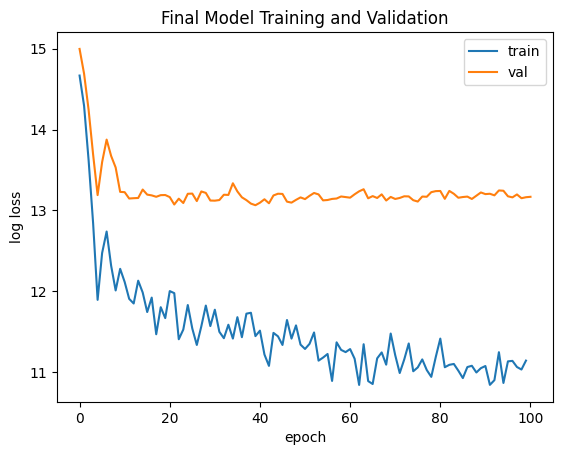

In [17]:
results_df = pd.DataFrame(results).T

#train_loss.insert(0, train_loss[0])
#train_loss.pop(0)

plt.plot(np.log(train_loss))
plt.plot(np.log(results_df.mean()))

plt.xlabel("epoch")
plt.ylabel("log loss")
#plt.ylim(top=2.5)
plt.title("Final Model Training and Validation")
plt.legend(["train","val"])
plt.show()

In [18]:
print(results_df.mean().argmin())
print(results_df.mean().min())

39
471878.9296875


In [14]:
args.phase = "train_val"

train_dataset = My_Dataset(args)

train_dataloader = DataLoader(train_dataset,
                           batch_size = 1,
                           num_workers= 4,
                           shuffle = False)

args.phase = "val"

val_dataset = My_Dataset(args)

val_dataloader = DataLoader(val_dataset,
                           batch_size = 1,
                           num_workers= 4,
                           shuffle = False)

args.phase = "test"

test_dataset = My_Dataset(args)

test_dataloader = DataLoader(test_dataset,
                           batch_size = 1,
                           num_workers= 4,
                           shuffle = False)

3388
Gender Index(['Female', 'Male'], dtype='object')
Survival Status Index(['Alive', 'Dead'], dtype='object')
Chemotherapy Index(['No', 'Yes'], dtype='object')
Radiation Index(['No', 'Yes'], dtype='object')
Recurrence Index(['no', 'yes'], dtype='object')
3388
Gender Index(['Female', 'Male'], dtype='object')
Survival Status Index(['Alive', 'Dead'], dtype='object')
Chemotherapy Index(['No', 'Yes'], dtype='object')
Radiation Index(['No', 'Yes'], dtype='object')
Recurrence Index(['no', 'yes'], dtype='object')
3388
Gender Index(['Female', 'Male'], dtype='object')
Survival Status Index(['Alive', 'Dead'], dtype='object')
Chemotherapy Index(['No', 'Yes'], dtype='object')
Radiation Index(['No', 'Yes'], dtype='object')
Recurrence Index(['no', 'yes'], dtype='object')


In [15]:
# to get the inputs, outputs and targets of the chosen model

from tqdm import tqdm

if not args.no_cuda:
  device = "cuda:0"
else:
  device = None

with torch.no_grad():

  clirad_model = CliRadModel(123,123,123)
  RNA_model = RNAModel(5004)
  clirnarad_model = CliRnaRadModel(clirad_model, RNA_model)
  clirnarad_model.to(torch.float)

  resnet_model = generate_model(args)

  clirnarad_model.layers = torch.nn.Sequential(*[clirnarad_model.layers[i] for i in range(len(clirnarad_model.layers)-1)])
  checkpoint = torch.load(args.pretrain_path)

  epoch_model = checkpoint["epoch"]
  final_model = FinalModel(args, resnet_model, clirnarad_model)
  final_model.to(device)

  final_model.load_state_dict(checkpoint["model"])
  final_model.eval()

  train_target_list = []
  train_output_list = []
  train_events = []

  for batch_idx, (ct, clinical, rna, radiomic, days_survived, survival_status) in enumerate(tqdm(train_dataloader)):
      # send data to device
      ct = ct.to(device)
      clinical = clinical.to(device)
      rna = rna.to(device)
      radiomic = radiomic.to(device)

      #days_survived = days_survived.to(device)
      #print(days_survived)

      # forward pass
      output = final_model(ct, clinical, rna, radiomic)

      train_target_list.append(days_survived.item())
      train_output_list.append(output.item())
      train_events.append(survival_status.item())

      # train_target_list.append(np.argmax(survival_status.detach().numpy()))
      # train_output_list.append(np.argmax(output.cpu().detach().numpy()))

  val_target_list = []
  val_output_list = []
  val_events = []


  for batch_idx, (ct, clinical, rna, radiomic, days_survived, survival_status) in enumerate(tqdm(val_dataloader)):

      ct = ct.to(device)
      clinical = clinical.to(device)
      rna = rna.to(device)
      radiomic = radiomic.to(device)
      #days_survived = days_survived.to(device)
      #print(days_survived)

      # forward pass
      output = final_model(ct, clinical, rna, radiomic)

      val_target_list.append(days_survived.item())
      val_output_list.append(output.item())
      val_events.append(survival_status.item())

      # val_target_list.append(np.argmax(survival_status.detach().numpy()))
      # val_output_list.append(np.argmax(output.cpu().detach().numpy()))



  test_target_list = []
  test_output_list = []
  test_events = []

  for batch_idx, (ct, clinical, rna, radiomic, days_survived, survival_status) in enumerate(tqdm(test_dataloader)):

      ct = ct.to(device)
      clinical = clinical.to(device)
      rna = rna.to(device)
      radiomic = radiomic.to(device)
      #days_survived = days_survived.to(device)
      #print(days_survived)

      # forward pass
      output = final_model(ct, clinical, rna, radiomic)

      test_target_list.append(days_survived.item())
      test_output_list.append(output.item())
      test_events.append(survival_status.item())

100%|██████████| 16/16 [02:07<00:00,  7.97s/it]


In [16]:
train_bool_events = [x==1 for x in train_events]

last_time = np.array(np.array(train_target_list))

estimate = 1/np.array(train_output_list)
print(concordance_index_censored(train_bool_events, last_time, estimate))

(0.9337349397590361, 1085, 77, 0, 1)


In [17]:
val_bool_events = [x==1 for x in val_events]

last_time = np.array(np.array(val_target_list))

estimate = 1/np.array(val_output_list)
print(concordance_index_censored(val_bool_events, last_time, estimate))

(0.7868852459016393, 48, 13, 0, 0)


In [18]:
test_bool_events = [x==1 for x in test_events]

last_time = np.array(np.array(test_target_list))

estimate = 1/np.array(test_output_list)
print(concordance_index_censored(test_bool_events, last_time, estimate))

(0.6744186046511628, 58, 28, 0, 0)


In [ ]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef

# train_conf = confusion_matrix(train_target_list, train_output_list)
# train_mcc = matthews_corrcoef(train_target_list, train_output_list)

# val_conf = confusion_matrix(val_target_list, val_output_list)
# val_mcc = matthews_corrcoef(val_target_list, val_output_list)

# test_conf = confusion_matrix(test_target_list, test_output_list)
# test_mcc = matthews_corrcoef(test_target_list, test_output_list)

# print(train_conf)
# print(train_mcc)

# print(val_conf)
# print(val_mcc)

# print(test_conf)
# print(test_mcc)

In [22]:
from sklearn.linear_model import LinearRegression

MSEloss = torch.nn.MSELoss()
L1loss = torch.nn.L1Loss()

train_regressor = LinearRegression()

train_regressor.fit(X = np.array(train_target_list).reshape(-1,1), y= np.array(train_output_list).reshape(-1,1))

train_MSEloss = MSEloss(torch.Tensor(train_target_list), torch.Tensor(train_output_list))
train_L1loss = L1loss(torch.Tensor(train_target_list), torch.Tensor(train_output_list))

train_y = train_regressor.predict(np.arange(3500).reshape(-1,1))

val_regressor = LinearRegression()

val_regressor.fit(X = np.array(val_target_list).reshape(-1,1), y= np.array(val_output_list).reshape(-1,1))

val_MSEloss = MSEloss(torch.Tensor(val_target_list), torch.Tensor(val_output_list))
val_L1loss = L1loss(torch.Tensor(val_target_list), torch.Tensor(val_output_list))

val_y = val_regressor.predict(np.arange(3500).reshape(-1,1))

test_regressor = LinearRegression()

test_regressor.fit(X = np.array(test_target_list).reshape(-1,1), y= np.array(test_output_list).reshape(-1,1))

test_MSEloss = MSEloss(torch.Tensor(test_target_list), torch.Tensor(test_output_list))
test_L1loss = L1loss(torch.Tensor(test_target_list), torch.Tensor(test_output_list))

test_y = test_regressor.predict(np.arange(3500).reshape(-1,1))



In [23]:
print(train_regressor.coef_)
print(train_regressor.intercept_)

print(val_regressor.coef_)
print(val_regressor.intercept_)

print(test_regressor.coef_)
print(test_regressor.intercept_)

# print("")

print(np.sqrt(train_MSEloss), train_L1loss)
print(np.sqrt(val_MSEloss), val_L1loss)
print(np.sqrt(test_MSEloss), test_L1loss)

[[0.61548298]]
[672.89975678]
[[0.23886121]]
[1296.7940053]
[[0.39497558]]
[1309.20882123]
tensor(549.6733) tensor(385.8617)
tensor(719.4070) tensor(587.4918)
tensor(1129.8402) tensor(877.9348)


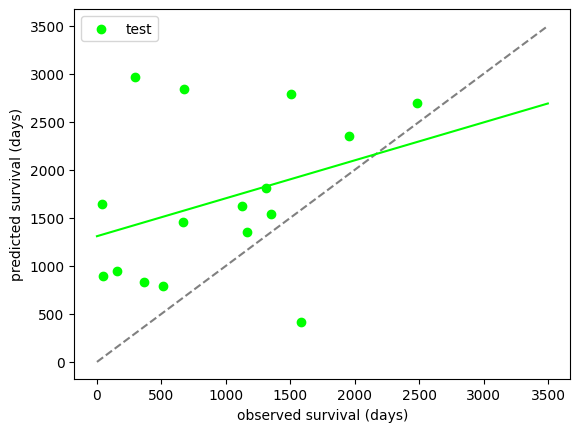

In [32]:
#blue: train
#red: val
#green: test

# plt.scatter(train_target_list, train_output_list, c="blue")
# plt.scatter(val_target_list, val_output_list, c="red")
plt.scatter(test_target_list, test_output_list, c="lime")

plt.plot(range(3500), range(3500), "--", c = "gray")
# plt.plot(range(3500), train_y, c="blue")
# plt.plot(range(3500), val_y, c="red")
plt.plot(range(3500), test_y, c="lime")

plt.xlabel("observed survival (days)")
plt.ylabel("predicted survival (days)")

# plt.legend(["train", "val"])
plt.legend(["test"])
plt.show()

In [ ]:
args.phase = "val"

my_dataset = My_Dataset(args)

my_dataloader = DataLoader(my_dataset,
                           batch_size = 1,
                           shuffle = False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-111b6768e9a1>", line 3, in <cell line: 3>
    my_dataset = My_Dataset(args)
  File "/content/drive/.shortcut-targets-by-id/1g-o-tVfVDSqEglK2hz1RSl75g30NM35n/Med3D/my_dataset.py", line 19, in __init__
    self.clinical_raw = pd.read_csv("ClinicalData.csv")
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 950, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 605, in _read
    parser = TextFi

In [ ]:
my_iterator = iter(my_dataloader)

In [ ]:
ct, clinical, rna, days_survived, survival_status = next(my_iterator)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-00be36c2b8e2>", line 1, in <cell line: 1>
    ct, clinical, rna, days_survived, survival_status = next(my_iterator)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1345, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1371, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.10/dist-packages/torch/_utils.py", line 694, in reraise
    raise exception
OSError: Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-00be36c2b8e2>", line 1, in <cell line: 1>
    ct, clinical, rna, days_survived, survival_status = next(my_iterator)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1345, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1371, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.10/dist-packages/torch/_utils.py", line 694, in reraise
    raise exception
OSError: Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/

In [ ]:

fig, (ax00,ax01) = plt.subplots(1,2,constrained_layout=True)

cnt = 0
def update(frame):

    global cnt, ct

    ax00.clear()
    ax01.clear()

    ax00.imshow(ct[0,0,cnt,:,:])
    ax00.set_title("CT")

    ax01.imshow(ct[0,1,cnt,:,:])
    ax01.set_title("seg")

    if cnt < 127:
      print(f"{cnt} finished...")
      cnt += 1
    else:
      print("done!")

ani = animation.FuncAnimation(
    fig, update)

    # per salvare il video
file_name = "boh.mp4"

writervideo = animation.FFMpegWriter(fps=6)
ani.save("/content/drive/MyDrive/"+file_name, writer=writervideo)
plt.close()

<ipython-input-40-5928a75ab62b>:23: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-5928a75ab62b>", line 30, in <cell line: 30>
    ani.save("/content/drive/MyDrive/"+file_name, writer=writervideo)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py", line 1090, in save
    anim._init_draw()  # Clear the initial frame
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py", line 1748, in _init_draw
    self._draw_frame(frame_data)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py", line 1767, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-40-5928a75ab62b>", line 11, in update
    ax00.imshow(ct[0,0,cnt,:,:])
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/__init__.py", line 1442, in inner
    return func(ax, *map(sanitize_sequence,

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <function _draw_all_if_interactive at 0x7f7c110fe830> (for post_execute):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-5928a75ab62b>", line 30, in <cell line: 30>
    ani.save("/content/drive/MyDrive/"+file_name, writer=writervideo)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py", line 1090, in save
    anim._init_draw()  # Clear the initial frame
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py", line 1748, in _init_draw
    self._draw_frame(frame_data)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py", line 1767, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-40-5928a75ab62b>", line 11, in update
    ax00.imshow(ct[0,0,cnt,:,:])
  File "/usr/local/lib/python3.10/dist-packa